In [1]:
import pandas as pd
import numpy as np
import math
import random
import os
import matplotlib.pyplot as plt
import parallel_plume_sim as pps
import multiprocessing
from scipy.interpolate import splprep, splev



##animating
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go
import plotly.io as py

## training
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [27]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device  # Add this line
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # 1 output (odor)

    def forward(self, x):
        if x.dim() == 3:  # If a batch of sequences is passed in
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        elif x.dim() == 2:  # If a single sequence is passed in
            h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
            c0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(self.device)
        else:
            raise ValueError("Unexpected input dimension: %d" % x.dim())
        out, _ = self.lstm(x.unsqueeze(0) if x.dim() == 2 else x, (h0, c0))
        out = self.fc(out.squeeze(0) if x.dim() == 2 else out[:, -1, :])
        return out

    def reset_hidden_state(self, batch_size):
        self.hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device),
                       torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device))


In [75]:
def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

def load_and_preprocess_file(file_path, features, target):
    # Load the data
    df = pd.read_hdf(file_path)
    df['scaled_odor']=scale_data(df.odor)
    # Scale the features
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    # Convert data to PyTorch tensors
    feature_tensors = torch.Tensor(df[features].values)
    target_tensors = torch.Tensor(df[target].values)

    # Reshape to (seq_length, n_features)
    feature_tensors = feature_tensors.view(-1, len(features))

    return feature_tensors, target_tensors

def create_sequences(feature_tensors, target_tensors, seq_length):
    sequences = []
    targets = []
    for i in range(len(feature_tensors) - seq_length):
        sequences.append(feature_tensors[i:i+seq_length])
        targets.append(target_tensors[i+seq_length])
    return torch.stack(sequences), torch.stack(targets)


def train_on_single_file(model, optimizer, criterion, sequences, targets, num_epochs, batch_size):
    model.train()
    num_batches = len(sequences) // batch_size  # Determine the number of batches
    
    for epoch in range(num_epochs):
        for batch_idx in range(num_batches):  # Iterate over each batch
            # Get the current batch of sequences and targets
            batch_sequences = sequences[batch_idx * batch_size : (batch_idx + 1) * batch_size]
            batch_targets = targets[batch_idx * batch_size : (batch_idx + 1) * batch_size]

            # Reset the hidden state for each new batch
            model.reset_hidden_state(batch_size)

            # Forward pass
            outputs = model(batch_sequences.view(-1, seq_length, input_size))
            # loss = criterion(outputs[:, -1, :], batch_targets.view(-1, 1))  # Compare only the last prediction with the target
            loss = criterion(outputs[:, -1], batch_targets.view(-1, 1))  # Compare only the last prediction with the target

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


def predict_on_new_data(model, new_data_path, features, target, seq_length, device):
    # Load and preprocess the new data
    feature_tensors, target_tensors = load_and_preprocess_file(new_data_path, features, target)
    sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)

    # Move sequences to the device
    sequences = sequences.to(device)

    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(sequences.view(-1, seq_length, len(features)))

    # Convert the predictions to a numpy array
    predictions = predictions.cpu().numpy()

    return predictions


## faster method but needs more gpu
# def train_on_single_file(model, optimizer, criterion, sequences, targets, num_epochs):
#     model.train()
#     batch_size = sequences.size(0)
#     for epoch in range(num_epochs):
#         model.reset_hidden_state(batch_size)

#         # Forward pass
#         outputs = model(sequences.view(-1, seq_length, input_size))
#         loss = criterion(outputs, targets.view(-1, 1))  # Compare the output directly with the target

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if (epoch + 1) % 10 == 0:
#             print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')






In [76]:
features = ['windx', 'windy', 'x', 'y']
target = ['scaled_odor']
seq_length = 5  # Choose a suitable sequence length
num_epochs = 10  # Choose a suitable number of epochs


# Initialize LSTM model
input_size = 4  # Number of features
hidden_size = 128
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
model = LSTM(input_size, hidden_size, num_layers, device)
model.to(device)


optimizer = optim.Adam(model.parameters(), lr=0.01)  # Define your optimizer
criterion = nn.MSELoss()  # Define your loss function


In [61]:
# Iterate over files
filepath="/home/flybot/DataAnalysis/data/generated_data_plume_sim/train/"
for file in os.listdir(filepath):  # Replace with the actual path
    file_path = os.path.join(filepath, file)
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    sequences = sequences.to(device)
    targets = targets.to(device)
    # train_on_single_file(model, optimizer, criterion, sequences, targets, num_epochs)
    train_on_single_file(model, optimizer, criterion, sequences, targets, num_epochs, batch_size=32)  # Choose a suitable batch size


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.01808532327413559


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.0050918953493237495


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.05834674462676048


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.0062976861372590065


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.008961953222751617


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 1.23643159866333


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.05752386897802353


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.00040167602128349245


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.27129966020584106


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.0012557079317048192


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.004938620608299971


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.2635224461555481


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.7798603773117065


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.08098575472831726


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.0009875071700662374


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.04928028956055641


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.4132125973701477


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.9517428874969482


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.31662458181381226


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.06530102342367172


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.00046244118129834533


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.003657174063846469


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.005816061515361071


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.0018209705594927073


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.0011749851983040571


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.35117635130882263


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.7762632369995117


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.013561357744038105


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.1785554736852646


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.6023309826850891


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.18972709774971008


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.11903750896453857


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.47168490290641785


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.07858094573020935


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.17139747738838196


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.2454136312007904


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.08913896232843399


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.03166412189602852


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.10147222131490707


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.625408947467804


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.007361449301242828


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.007990467362105846


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.0027451757341623306


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.01592877134680748


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.06693623214960098


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.00487101823091507


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.2604302167892456


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.18927502632141113


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.35416385531425476


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.6045824885368347


/home/flybot/DataAnalysis/pyresearch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/10], Loss: 0.5622366070747375


In [90]:
new_data_path = "/home/flybot/DataAnalysis/data/generated_data_plume_sim/test/diag1.h5"
predictions = predict_on_new_data(model, new_data_path, features, target, seq_length, device)


In [87]:
test = pd.read_hdf(new_data_path)

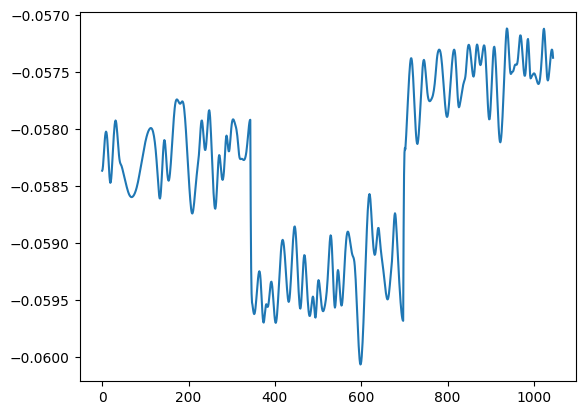

In [94]:
# plt.plot(test.scaled_odor)
plt.plot(predictions)